In [1]:
import xarray as xr
import flox.xarray as fx
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import oceanmixedlayers.oceanmixedlayers as oml

ERROR 1: PROJ: proj_create_from_database: Open of /home.ufs/jp4778/.conda/envs/pangeo/share/proj failed


In [2]:
ds_globe = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [3]:
unique_prof = np.arange(len(ds_globe['N_PROF']))
ds_globe = ds_globe.assign_coords(N_PROF=('N_PROF', unique_prof))
ds_so = ds_globe.where(ds_globe.LATITUDE.compute()<-30, drop=True)

In [5]:
def get_ds_binned(ds, lon_bins, lat_bins):
    """
    Bin an xarray Dataset by 3-degree latitude and longitude bins,
    replacing Interval dimensions with bin centers.
    
    Parameters:
        ds : xarray.Dataset
            The dataset to bin.
        lon_bins : array-like
            Bin edges for longitude (e.g. np.arange(-180, 181, 3))
        lat_bins : array-like
            Bin edges for latitude (e.g. np.arange(-90, 91, 3))
    
    Returns:
        xarray.Dataset
            Binned dataset with dimensions (PRES_INTERPOLATED, lon_c, lat_c)
    """

    # Step 1: Bin with fx.xarray_reduce using IntervalIndex
    ds_binned = fx.xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins),
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Create left, right, center arrays
    lon_l = np.array(lon_bins[:-1])
    lon_r = np.array(lon_bins[1:])
    lon_c = (lon_l + lon_r) / 2

    lat_l = np.array(lat_bins[:-1])
    lat_r = np.array(lat_bins[1:])
    lat_c = (lat_l + lat_r) / 2

    # Step 3: Replace Interval dims with center dims
    ds_binned = ds_binned.assign_coords({
        "lon_c": ("LONGITUDE", [iv.mid for iv in ds_binned['LONGITUDE'].values]),
        "lat_c": ("LATITUDE", [iv.mid for iv in ds_binned['LATITUDE'].values]),
        "lon_l": ("LONGITUDE", lon_l),
        "lon_r": ("LONGITUDE", lon_r),
        "lat_l": ("LATITUDE", lat_l),
        "lat_r": ("LATITUDE", lat_r),
    })

    ds_binned = ds_binned.swap_dims({"LONGITUDE": "lon_c", "LATITUDE": "lat_c"})

    return ds_binned

In [43]:
n_profiles = ds_so.dims['N_PROF']

# Randomly choose 200 unique profile indices
random_indices = np.random.choice(n_profiles, size=10000, replace=False)

# Select those profiles from the dataset
ds_random_subset = ds_so.isel(N_PROF=random_indices)

/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 45 times more chunks
  return self.array[key]


In [45]:
ref = 10
delta = 0.03

def compute_mld_profile(pres, sig0):

    valid = ~np.isnan(sig0)
    pres_clean = pres[valid]
    sig0_clean = sig0[valid]

    if len(sig0_clean) == 0:
        return np.nan

    try:
        mld = oml.threshold(pres_clean, sig0_clean, delta=delta, ref=ref)[0]
        return mld
    except Exception:
        return np.nan

In [46]:
n_total = ds_so.dims['N_PROF']

# How many profiles you want
n_subset = 200  # or however many you want

# Random unique indices
np.random.seed(42)  # for reproducibility
rand_indices = np.random.choice(n_total, size=n_subset, replace=False)
ds_subset = ds_so.isel(N_PROF=xr.DataArray(rand_indices, dims="N_PROF"))

In [47]:
ds_subset = ds_subset.load()

In [48]:
mld_thresh = xr.apply_ufunc(
    compute_mld_profile,
    ds_subset['PRES_INTERPOLATED'],
    ds_subset['SIG0'],
    input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
)

In [49]:
ds_subset['mld_thresh'] = mld_thresh

In [197]:
prof = ds_subset.isel(N_PROF=188)


In [198]:


# Extract variables
pres = prof['PRES_INTERPOLATED'].values  # in dbar
ct = prof['CT'].values
sa = prof['SA'].values

# Mask NaNs
mask = ~np.isnan(pres) & ~np.isnan(ct) & ~np.isnan(sa)
pres = pres[mask]
ct = ct[mask]
sa = sa[mask]
sig0 = prof['SIG0'].values[mask]

dp = np.full_like(pres, -2.0)

# Compute PEA-based MLD
mld_pea = oml.mld_delta_pe(pres, dp, ct, sa, coord='pressure', energy=25.0)
print(f"PEA-based MLD: {mld_pea.item():.2f} dbar")

PEA-based MLD: 49.42 dbar


In [ ]:
# Extract variables
pres = prof['PRES_INTERPOLATED'].values  # in dbar
ct = prof['CT'].values
sa = prof['SA'].values

# Mask NaNs
mask = ~np.isnan(pres) & ~np.isnan(ct) & ~np.isnan(sa)
pres = pres[mask]
ct = ct[mask]
sa = sa[mask]
sig0 = prof['SIG0'].values[mask]

dp = pres[:-1] 

# Compute PEA-based MLD
mld_pea = oml.mld_delta_pe(pres, dp, ct, sa, coord='pressure', energy=25.0)
print(f"PEA-based MLD: {mld_pea.item():.2f} dbar")

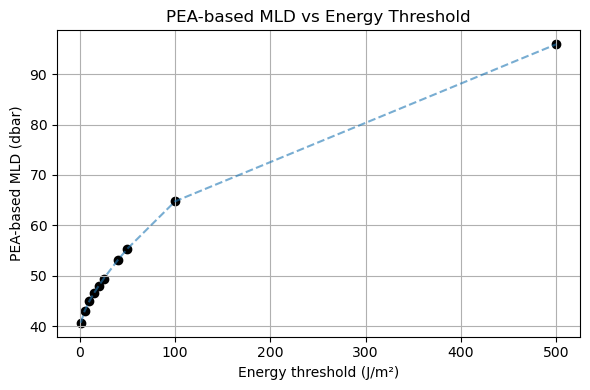

In [199]:
import matplotlib.pyplot as plt

energies = [1, 5, 10, 15, 20, 25, 40, 50, 100, 500]
mld_peas = [oml.mld_delta_pe(pres, dp, ct, sa, coord='pressure', energy=e).item() for e in energies]

plt.figure(figsize=(6, 4))
plt.scatter(energies, mld_peas, color='black')
plt.plot(energies, mld_peas, linestyle='--', alpha=0.6)
plt.xlabel("Energy threshold (J/m²)")
plt.ylabel("PEA-based MLD (dbar)")
plt.title("PEA-based MLD vs Energy Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()


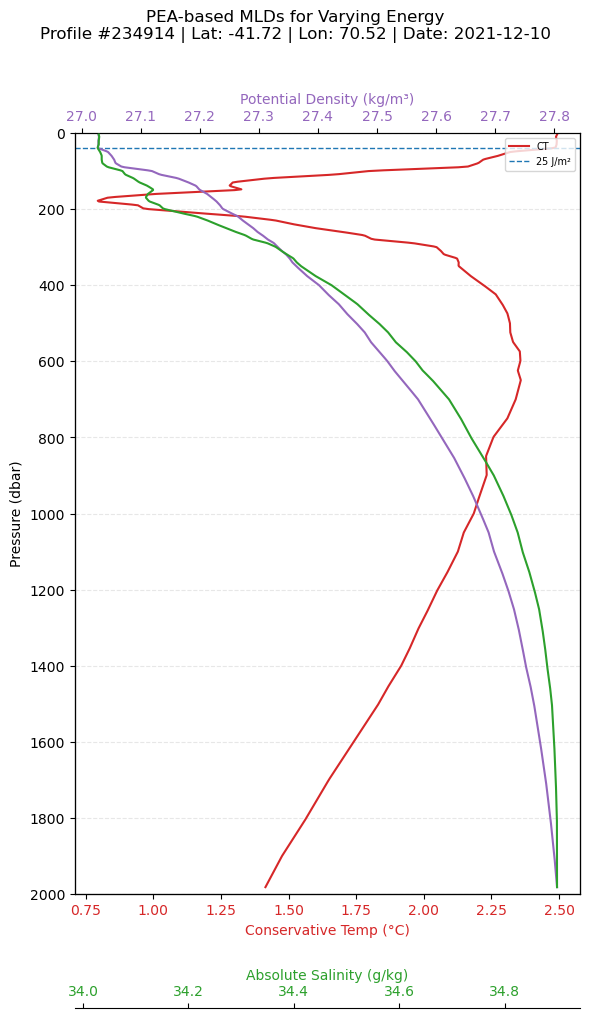

In [206]:
fig, ax_ct = plt.subplots(figsize=(6, 10))
ax_ct.invert_yaxis()

# Plot CT
ax_ct.plot(ct, pres, color='tab:red', label='CT')
ax_ct.set_xlabel("Conservative Temp (°C)", color='tab:red')
ax_ct.set_ylabel("Pressure (dbar)")
ax_ct.tick_params(axis='x', labelcolor='tab:red')
ax_ct.set_yticks(np.arange(0, 2001, 200))
ax_ct.grid(axis='y', linestyle='--', alpha=0.3)

# SIG0
ax_sig0 = ax_ct.twiny()
ax_sig0.plot(sig0, pres, color='tab:purple')
ax_sig0.set_xlabel("Potential Density (kg/m³)", color='tab:purple')
ax_sig0.tick_params(axis='x', labelcolor='tab:purple')

# SA
ax_sa = ax_ct.twiny()
ax_sa.spines["top"].set_position(("axes", -0.15))
ax_sa.plot(sa, pres, color='tab:green')
ax_sa.set_xlabel("Absolute Salinity (g/kg)", color='tab:green')
ax_sa.tick_params(axis='x', labelcolor='tab:green')
ax_sa.xaxis.set_label_position('top')
ax_sa.xaxis.set_ticks_position('top')

# Plot MLD lines
ax_ct.axhline(y=40, linestyle='--', linewidth=1, label=f'25 J/m²')

ax_ct.set_ylim(2000, 0)
ax_ct.legend(loc='upper right', fontsize=7)
plt.suptitle(
    f'PEA-based MLDs for Varying Energy\n'
    f'Profile #{prof.N_PROF.values.item()} | Lat: {prof.LATITUDE.values:.2f} | Lon: {prof.LONGITUDE.values:.2f} | '
    f'Date: {np.datetime_as_string(prof.TIME.values, unit="D")}',
    y=1.02
)
plt.tight_layout()
plt.show()


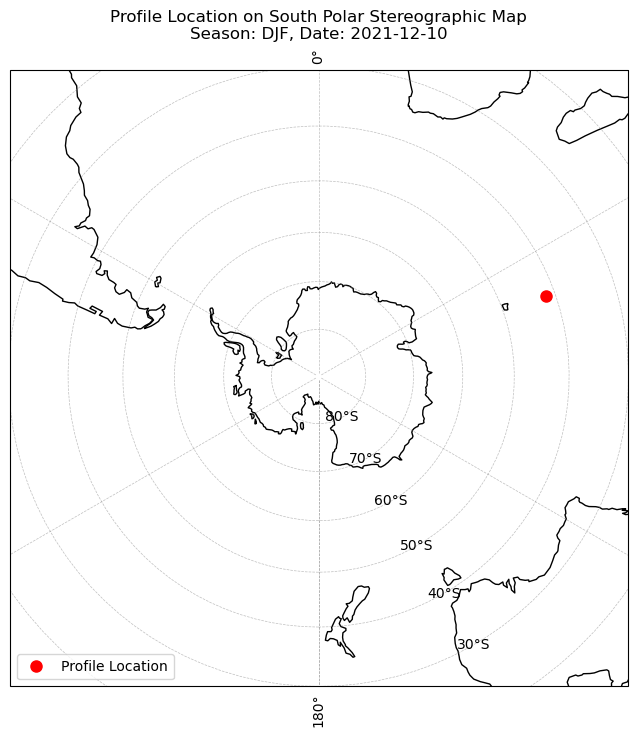

In [203]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Select the profile
prof = ds_subset.isel(N_PROF=0)

# Get coordinates
lon = prof['LONGITUDE'].values
lat = prof['LATITUDE'].values

# --- Plot ---
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot the location
ax.plot(lon, lat, 'ro', markersize=8, transform=ccrs.PlateCarree(), label='Profile Location')

# Set extent (optional – zoom in around Antarctica)
ax.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())
season = prof['TIME'].dt.season.values.item()
# Title and legend
plt.title(f"Profile Location on South Polar Stereographic Map\nSeason: {season}, Date: {pd.to_datetime(prof.TIME.values).date()}")
plt.legend(loc='lower left')
plt.show()


In [66]:
pres = prof['PRES_INTERPOLATED'].values
ct = prof['CT'].values
sa = prof['SA'].values
mask = ~np.isnan(pres) & ~np.isnan(ct) & ~np.isnan(sa)
pres, ct, sa = pres[mask], ct[mask], sa[mask]
dp = np.full_like(pres, 2.0)

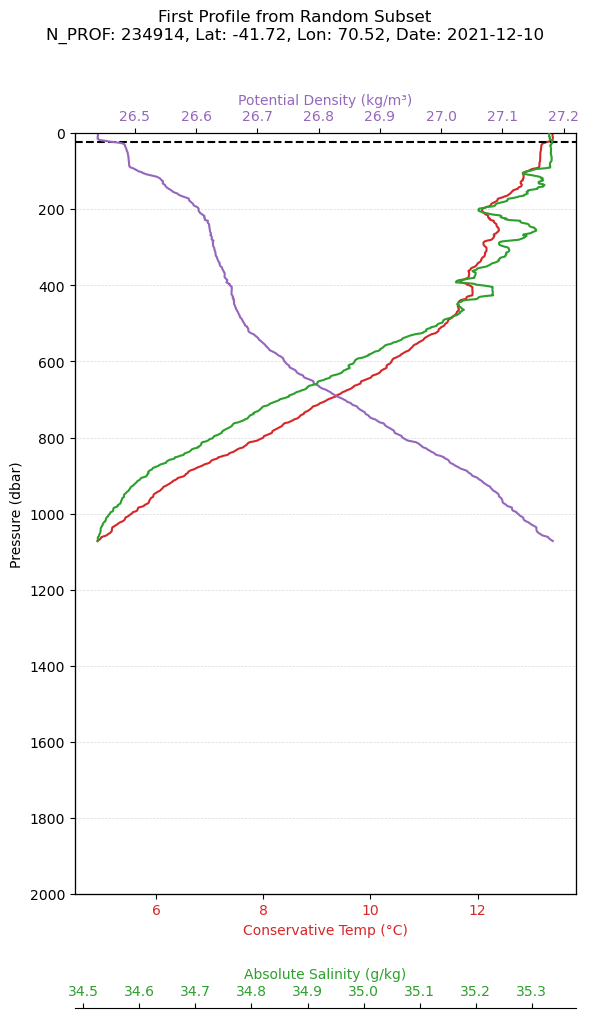

In [74]:
import matplotlib.pyplot as plt
import numpy as np


# Grab profile
i = 0
prof = ds_subset.isel(N_PROF = i)
mld = mld_thresh.isel(N_PROF = i).values

# Pressure
y = prof.PRES_INTERPOLATED.values

# --- Plot ---
fig, ax_ct = plt.subplots(figsize=(6, 10))
ax_ct.invert_yaxis()

# CT (main x-axis)
ax_ct.plot(prof.CT, y, color='tab:red', label='CT')
ax_ct.set_xlabel("Conservative Temp (°C)", color='tab:red')
ax_ct.set_ylabel("Pressure (dbar)")
ax_ct.tick_params(axis='x', labelcolor='tab:red')
ax_ct.set_yticks(np.arange(0, 2001, 200))
ax_ct.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# SIG0 (top axis)
ax_sig0 = ax_ct.twiny()
ax_sig0.plot(prof.SIG0, y, color='tab:purple', label='SIG0')
ax_sig0.set_xlabel("Potential Density (kg/m³)", color='tab:purple')
ax_sig0.tick_params(axis='x', labelcolor='tab:purple')

# SA (offset axis)
ax_sa = ax_ct.twiny()
ax_sa.spines["top"].set_position(("axes", -0.15))
ax_sa.plot(prof.SA, y, color='tab:green', label='SA')
ax_sa.set_xlabel("Absolute Salinity (g/kg)", color='tab:green')
ax_sa.tick_params(axis='x', labelcolor='tab:green')
ax_sa.xaxis.set_label_position('top')
ax_sa.xaxis.set_ticks_position('top')


# MLD line
ax_ct.axhline(y=mld, color='black', linestyle='--', linewidth=1.5,
              label=f'MLD (0.03 threshold): {mld:.1f} dbar')

# Final layout and title
ax_ct.set_ylim(2000, 0)
plt.suptitle(
    'First Profile from Random Subset\n'
    f'N_PROF: {prof.N_PROF.values.item()}, Lat: {prof.LATITUDE.values:.2f}, Lon: {prof.LONGITUDE.values:.2f}, '
    f'Date: {np.datetime_as_string(prof.TIME.values, unit="D")}',
    y=1.02
)
plt.tight_layout()
plt.show()


In [435]:
ref_depth = 10
p_interp = ds_so['PRES_INTERPOLATED'].values
ref_idx = np.argmin(np.abs(p_interp - ref_depth))

# Boolean mask where SIG0 is nan at the ref_idx
missing_at_ref = np.isnan(ds_so['SIG0'].isel(PRES_INTERPOLATED=ref_idx))

# Get first profile index where SIG0 is missing at 10 dbar
missing_profiles = ds_so['N_PROF'][missing_at_ref]
if len(missing_profiles) > 0:
    prof = ds_so.sel(N_PROF=missing_profiles[0].values)
    print(f"Found profile with missing SIG0 at 10 dbar: N_PROF = {prof.N_PROF.values}")
else:
    print("No profiles found with missing SIG0 at 10 dbar.")


Found profile with missing SIG0 at 10 dbar: N_PROF = 5892


In [440]:
ds_so.sel(N_PROF = 5892)['SIG0'].values[0:20]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, 26.78376531, 26.7861232 ,
       26.7884811 , 26.79083899, 26.79319688, 26.79572048, 26.79840978,
       26.80109908, 26.80378837, 26.80647767, 26.80904368, 26.81148639])